In [2]:
import tensorflow as tf
# from tensorflow.keras import models, layers => error version
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt 

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS= 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-18 11:57:55.834094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 11:57:55.834734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
len(dataset)


68

In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
32*68

2176

In [9]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2023-01-18 11:57:56.261965: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


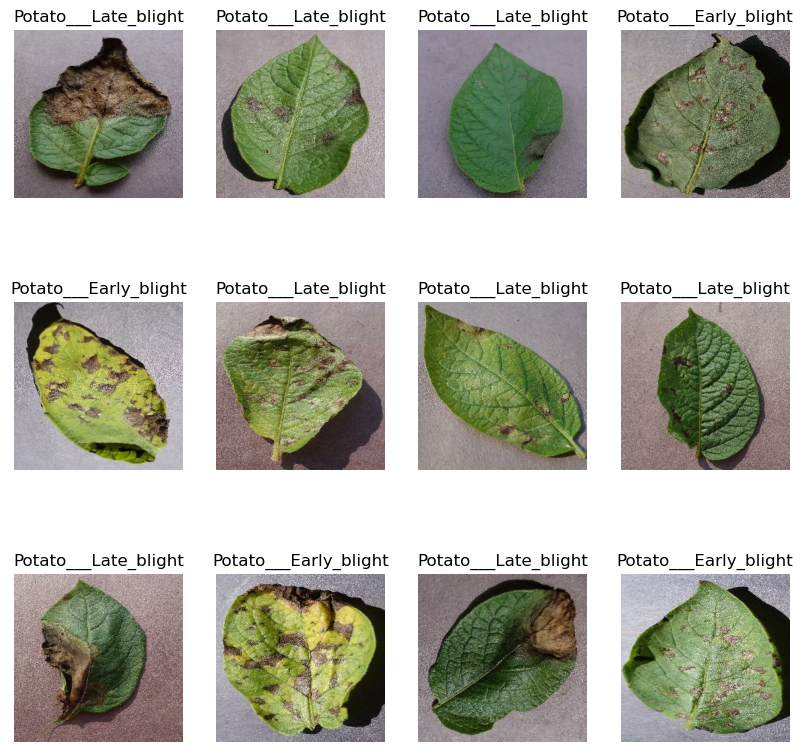

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4 ,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

68

In [12]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1 , shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds)

54

In [31]:
len(val_ds)

6

In [32]:
len(test_ds)

8

In [36]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
resize_and_rescale =tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [40]:
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, (3,3) , activation='relu', input_shape = input_shape),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, kernel_size= (3,3) , activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, kernel_size= (3,3) , activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (256, 256, 3)             0         
                                                                 
 sequential_3 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [45]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [46]:
history=model.fit(
  train_ds,
  epochs=EPOCHS,
  batch_size = BATCH_SIZE,
  verbose=1,
  validation_data=val_ds
)

Epoch 1/50


2023-01-19 19:18:20.021915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.8916 - accuracy: 0.5017WARNING:tensorflow:Model was constructed with shape (256, 256, 3) for input KerasTensor(type_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name='resizing_2_input'), name='resizing_2_input', description="created by layer 'resizing_2_input'"), but it was called on an input with incompatible shape (None, 256, 256, 3).


2023-01-19 19:18:47.008831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 30s 462ms/step - loss: 0.8916 - accuracy: 0.5017 - val_loss: 0.9811 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 29s 538ms/step - loss: 0.7068 - accuracy: 0.6823 - val_loss: 0.4724 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 24s 449ms/step - loss: 0.3734 - accuracy: 0.8461 - val_loss: 0.4184 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 22s 402ms/step - loss: 0.3010 - accuracy: 0.8750 - val_loss: 0.3452 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 22s 407ms/step - loss: 0.2441 - accuracy: 0.9109 - val_loss: 0.2381 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 22s 414ms/step - loss: 0.2180 - accuracy: 0.9184 - val_loss: 0.2463 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 23s 425ms/step - loss: 0.1677 - accuracy: 0.9329 - val_loss: 0.2078 - val_accuracy: 0.9115
Epoch 8/50

In [47]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 38ms/step - loss: 0.1841 - accuracy: 0.9414


In [48]:
scores

[0.1840556561946869, 0.94140625]

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history.history['accuracy']

[0.5017361044883728,
 0.6822916865348816,
 0.8460648059844971,
 0.875,
 0.9108796119689941,
 0.9184027910232544,
 0.9328703880310059,
 0.928819477558136,
 0.9473379850387573,
 0.9380787014961243,
 0.9589120149612427,
 0.960069477558136,
 0.9519675970077515,
 0.9664351940155029,
 0.9681712985038757,
 0.9565972089767456,
 0.9780092835426331,
 0.9629629850387573,
 0.9762731790542603,
 0.9791666865348816,
 0.9652777910232544,
 0.9745370149612427,
 0.9791666865348816,
 0.9803240895271301,
 0.9699074029922485,
 0.9855324029922485,
 0.9872685074806213,
 0.9878472089767456,
 0.9924768805503845,
 0.9855324029922485,
 0.9809027910232544,
 0.984375,
 0.984375,
 0.9814814925193787,
 0.9884259104728699,
 0.991319477558136,
 0.9907407760620117,
 0.9936342835426331,
 0.9953703880310059,
 0.9924768805503845,
 0.9890046119689941,
 0.9878472089767456,
 0.9855324029922485,
 0.9895833134651184,
 0.9918981790542603,
 0.9959490895271301,
 0.9814814925193787,
 0.9965277910232544,
 0.9918981790542603,
 0.9947